In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import math
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# load training and test datasets
test_set = pd.read_csv('../input/test_set.csv', parse_dates=[2,])
train_set = pd.read_csv('../input/train_set.csv', parse_dates=[2,])
tube              = pd.read_csv('../input/tube.csv', parse_dates=True)
specs             = pd.read_csv('../input/specs.csv', parse_dates=[2,])
bill_of_materials = pd.read_csv('../input/bill_of_materials.csv', parse_dates=True)
comp_adaptor      = pd.read_csv('../input/comp_adaptor.csv', parse_dates=[2,])
comp_boss         = pd.read_csv('../input/comp_boss.csv', parse_dates=[2,])
comp_elbow        = pd.read_csv('../input/comp_elbow.csv', parse_dates=[2,])
comp_float        = pd.read_csv('../input/comp_float.csv', parse_dates=[2,])
comp_hfl          = pd.read_csv('../input/comp_hfl.csv', parse_dates=[2,])
comp_nut          = pd.read_csv('../input/comp_nut.csv', parse_dates=[2,])
comp_other        = pd.read_csv('../input/comp_other.csv', parse_dates=[2,])
comp_sleeve       = pd.read_csv('../input/comp_sleeve.csv', parse_dates=[2,])
comp_straight     = pd.read_csv('../input/comp_straight.csv', parse_dates=[2,])
comp_tee          = pd.read_csv('../input/comp_tee.csv', parse_dates=[2,])
comp_threaded     = pd.read_csv('../input/comp_threaded.csv', parse_dates=[2,])
components        = pd.read_csv('../input/components.csv', parse_dates=[2,])
test_set          = pd.read_csv('../input/test_set.csv', parse_dates=[2,])
train_set         = pd.read_csv('../input/train_set.csv', parse_dates=[2,])
tube_end_form     = pd.read_csv('../input/tube_end_form.csv', parse_dates=True)
tube              = pd.read_csv('../input/tube.csv', parse_dates=True)
type_component    = pd.read_csv('../input/type_component.csv', parse_dates=True)
type_connection   = pd.read_csv('../input/type_connection.csv', parse_dates=True)
type_end_form     = pd.read_csv('../input/type_end_form.csv', parse_dates=True)


In [3]:
labels = train_set.cost.values
label_log = np.log1p(labels)

In [4]:
BoF_1 = bill_of_materials[['tube_assembly_id','component_id_1','quantity_1']]
BoF_2 = bill_of_materials[['tube_assembly_id','component_id_2','quantity_2']]
comp_adaptor = pd.merge(comp_adaptor,type_component,on='component_type_id',how='inner')
comp_boss = pd.merge(comp_boss,type_component,on='component_type_id',how='inner')
comp_elbow = pd.merge(comp_elbow,type_component,on='component_type_id',how='inner')
comp_float = pd.merge(comp_float,type_component,on='component_type_id',how='inner')
comp_hfl = pd.merge(comp_hfl,type_component,on='component_type_id',how='inner')
comp_nut  = pd.merge(comp_nut,type_component,on='component_type_id',how='inner')
comp_sleeve  = pd.merge(comp_sleeve,type_component,on='component_type_id',how='inner')
comp_straight  = pd.merge(comp_sleeve,type_component,on='component_type_id',how='inner')
comp_tee  = pd.merge(comp_straight,type_component,on='component_type_id',how='inner')
comp_threaded  = pd.merge(comp_threaded,type_component,on='component_type_id',how='inner')


In [5]:
def merge_test_train_spec_tube(df):
    df = pd.merge(df,tube,on='tube_assembly_id')
    df = pd.merge(df,specs,on='tube_assembly_id')
    return df


In [6]:
train_set = merge_test_train_spec_tube(train_set)
test_set = merge_test_train_spec_tube(test_set)

In [7]:
test_set = test_set.drop(['spec10'], axis=1)
train_set = train_set.drop(['spec10'], axis=1)
bill_of_materials = bill_of_materials.drop(['component_id_5','quantity_5','component_id_6',
                                            'quantity_6', 'component_id_7','quantity_7', 'component_id_8','quantity_8'], axis=1)
comp_threaded = comp_threaded.drop(['end_form_id_3', 'connection_type_id_3','length_3','thread_size_3',
                                   'thread_pitch_3', 'nominal_size_3', 'end_form_id_4','connection_type_id_4',
                                   'length_4','thread_size_4','thread_pitch_4', 'nominal_size_4'],axis=1)

In [8]:
train_set = pd.merge(train_set,bill_of_materials,on='tube_assembly_id',how='inner')
test_set = pd.merge(test_set,bill_of_materials,on='tube_assembly_id',how='inner')

In [9]:
components = components.rename({'name':'name_components'}, axis=1)
components = components.drop(['component_type_id'], axis=1)

In [10]:
comp_adaptor  = pd.merge(comp_adaptor,components,on='component_id',how='left')
comp_boss  = pd.merge(comp_boss,components,on='component_id',how='left')
comp_elbow  = pd.merge(comp_elbow,components,on='component_id',how='left')
comp_float  = pd.merge(comp_float,components,on='component_id',how='left')
comp_hfl  = pd.merge(comp_hfl,components,on='component_id',how='left')
comp_nut  = pd.merge(comp_nut,components,on='component_id',how='left')
comp_sleeve = pd.merge(comp_sleeve,components,on='component_id',how='left')

In [11]:
comp_straight = comp_straight.drop(['name_y'],axis=1)
comp_straight = comp_straight.rename({'name_x':'name'}, axis=1)
comp_straight = pd.merge(comp_straight,components,on='component_id',how='left')

In [12]:
comp_tee = comp_tee.drop(['name_y','name_x'],axis=1)
comp_tee = pd.merge(comp_tee,components,on='component_id',how='left')

In [13]:
comp_threaded = pd.merge(comp_threaded,components,on='component_id',how='left')

In [14]:
type_end_form = type_end_form.rename({'name':'name_end_form_id'}, axis=1)

In [15]:
type_connection = type_connection.rename({'name':'name_type_connection_id'}, axis=1)

In [16]:
comp_threaded = pd.merge(comp_threaded,type_end_form,left_on='end_form_id_1',right_on='end_form_id',how='inner')
comp_threaded = comp_threaded.rename({'name_end_form_id':'name_end_form_id_1'}, axis=1)
comp_threaded = comp_threaded.drop(['end_form_id'],axis=1)
comp_threaded = pd.merge(comp_threaded,type_connection,left_on='connection_type_id_1',
                         right_on='connection_type_id',how='inner')
comp_threaded = comp_threaded.rename({'name_type_connection_id':'name_type_connection_id_1'}, axis=1)
comp_threaded = comp_threaded.drop(['connection_type_id'],axis=1)
comp_threaded = comp_threaded[['component_id', 'component_type_id', 'adaptor_angle', 'overall_length',
       'hex_size', 'end_form_id_1','name_end_form_id_1', 'connection_type_id_1','name_type_connection_id_1','length_1',
       'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2',
       'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2',
       'nominal_size_2', 'unique_feature', 'orientation', 'weight', 'name',
       'name_components']]

In [17]:
comp_adaptor = pd.merge(comp_adaptor,type_end_form,left_on='end_form_id_1',right_on='end_form_id',how='inner')
comp_adaptor = comp_adaptor.rename({'name_end_form_id':'name_end_form_id_1'}, axis=1)
comp_adaptor = comp_adaptor.drop(['end_form_id'],axis=1)
comp_adaptor = pd.merge(comp_adaptor,type_connection,left_on='connection_type_id_1',
                         right_on='connection_type_id',how='inner')
comp_adaptor = comp_adaptor.rename({'name_type_connection_id':'name_type_connection_id_1'}, axis=1)
comp_adaptor = comp_adaptor.drop(['connection_type_id'],axis=1)
comp_adaptor = comp_adaptor[['component_id', 'component_type_id', 'adaptor_angle', 'overall_length',
       'end_form_id_1','name_end_form_id_1', 'connection_type_id_1','name_type_connection_id_1','length_1',
       'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2',
       'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2',
       'nominal_size_2','hex_size', 'unique_feature', 'orientation', 'weight', 'name',
       'name_components']]

In [18]:
comp_boss = pd.merge(comp_boss,type_connection,left_on='connection_type_id',
                         right_on='connection_type_id',how='inner')
comp_boss = comp_boss[['component_id', 'component_type_id', 'type', 'connection_type_id', 'name_type_connection_id',
       'outside_shape', 'base_type', 'height_over_tube', 'bolt_pattern_long',
       'bolt_pattern_wide', 'groove', 'base_diameter', 'shoulder_diameter',
       'unique_feature', 'orientation', 'weight', 'name', 'name_components',
      ]]

In [19]:
comp_sleeve = pd.merge(comp_sleeve,type_connection,left_on='connection_type_id',
                         right_on='connection_type_id',how='inner')
comp_sleeve = comp_sleeve[['component_id', 'component_type_id', 'connection_type_id', 'name_type_connection_id','length',
       'intended_nut_thread', 'intended_nut_pitch', 'unique_feature',
       'plating', 'orientation', 'weight', 'name', 'name_components']]

In [20]:
comp_straight = pd.merge(comp_straight,type_connection,left_on='connection_type_id',
                         right_on='connection_type_id',how='inner')
comp_straight = comp_straight[['component_id', 'component_type_id', 'connection_type_id','name_type_connection_id', 'length',
       'intended_nut_thread', 'intended_nut_pitch', 'unique_feature',
       'plating', 'orientation', 'weight', 'name', 'name_components'
       ]]

In [21]:
comp_tee = pd.merge(comp_tee,type_connection,left_on='connection_type_id',
                         right_on='connection_type_id',how='inner')
comp_tee = comp_tee[['component_id', 'component_type_id', 'connection_type_id','name_type_connection_id', 'length',
       'intended_nut_thread', 'intended_nut_pitch', 'unique_feature',
       'plating', 'orientation', 'weight', 'name', 'name_components'
       ]]

In [22]:
bill_of_materials = bill_of_materials.drop(['component_id_3', 'quantity_3', 'component_id_4', 'quantity_4'],axis=1)

In [23]:
BoF_1 = bill_of_materials.drop(['component_id_2', 'quantity_2'],axis=1)
BoF_2 = bill_of_materials.drop(['component_id_1', 'quantity_1'],axis=1)

In [24]:
BoF_1_adaptor = pd.merge(BoF_1, comp_adaptor, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_boss = pd.merge(BoF_1, comp_boss, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_elbow = pd.merge(BoF_1, comp_elbow, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_float = pd.merge(BoF_1, comp_float, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_nut = pd.merge(BoF_1, comp_nut, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_other = pd.merge(BoF_1, comp_other, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_sleeve = pd.merge(BoF_1, comp_sleeve, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_straight = pd.merge(BoF_1, comp_straight, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_tee = pd.merge(BoF_1, comp_tee, left_on='component_id_1',right_on='component_id',how='right')
BoF_1_threaded = pd.merge(BoF_1, comp_threaded, left_on='component_id_1',right_on='component_id',how='right')

In [25]:
def concat_ordered_columns(frames, ax):
    columns_ordered = []
    for frame in frames:
        columns_ordered.extend(x for x in frame.columns if x not in columns_ordered)
    final_df = pd.concat(frames,ignore_index=True,axis=ax)    
    return final_df[columns_ordered]       


dfs = [BoF_1_adaptor,BoF_1_boss,BoF_1_elbow,BoF_1_float,BoF_1_float,BoF_1_nut,BoF_1_other,
       BoF_1_sleeve,BoF_1_straight,BoF_1_tee,BoF_1_threaded]
full_1 = concat_ordered_columns(dfs,0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [26]:
full_1 = full_1[pd.notnull(full_1['tube_assembly_id'])]

In [27]:
BoF_2_adaptor = pd.merge(BoF_2, comp_adaptor, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_boss = pd.merge(BoF_2, comp_boss, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_elbow = pd.merge(BoF_2, comp_elbow, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_float = pd.merge(BoF_2, comp_float, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_nut = pd.merge(BoF_2, comp_nut, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_other = pd.merge(BoF_2, comp_other, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_sleeve = pd.merge(BoF_2, comp_sleeve, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_straight = pd.merge(BoF_2, comp_straight, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_tee = pd.merge(BoF_2, comp_tee, left_on='component_id_2',right_on='component_id',how='right')
BoF_2_threaded = pd.merge(BoF_2, comp_threaded, left_on='component_id_2',right_on='component_id',how='right')

In [28]:
dfs = [BoF_2_adaptor,BoF_2_boss,BoF_2_elbow,BoF_2_float,BoF_2_float,BoF_2_nut,BoF_2_other,
       BoF_2_sleeve,BoF_2_straight,BoF_2_tee,BoF_2_threaded]
full_2 = concat_ordered_columns(dfs,0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [29]:
train_set = pd.merge(train_set, full_1, on='tube_assembly_id',how='left')
train_set = pd.merge(train_set, full_2, on='tube_assembly_id',how='left')

test_set = pd.merge(test_set, full_1, on='tube_assembly_id',how='left')
test_set = pd.merge(test_set, full_2, on='tube_assembly_id',how='left')

In [30]:
train_set = train_set.drop_duplicates()
test_set = test_set.drop_duplicates()

In [31]:
train_set['year'] = train_set.quote_date.dt.year
train_set['month'] = train_set.quote_date.dt.month
train_set['day'] = train_set.quote_date.dt.day

In [32]:
test_set['quote_date'] = pd.to_datetime(test_set['quote_date'])

In [33]:
test_set['quote_date'] = pd.to_datetime(test_set['quote_date'])

test_set['year'] = test_set.quote_date.dt.year
test_set['month'] = test_set.quote_date.dt.month
test_set['day'] = test_set.quote_date.dt.day

In [34]:

idx = test_set.id.values.astype(int)
test_set = test_set.drop(['id', 'tube_assembly_id', 'quote_date'], axis = 1)
labels = train_set.cost.values


train_set = train_set.drop(['quote_date', 'cost', 'tube_assembly_id'], axis = 1)

In [35]:
train_set.shape,test_set.shape

((30213, 150), (30235, 150))

In [36]:

for column in train_set:
    if train_set[column].isnull().any():
           if train_set[column].dtypes == 'object':
                values = train_set[column].value_counts().keys().tolist()
                counts = train_set[column].value_counts().tolist()
                if len(counts)!=0:
                    maxx = max(counts)
                    ind  = counts.index(maxx)
                    train_set[column] = train_set[column].fillna(values[ind])
                    
                    
for column in test_set:
    if test_set[column].isnull().any():
           if test_set[column].dtypes == 'object':
                values = test_set[column].value_counts().keys().tolist()
                counts = test_set[column].value_counts().tolist()
                if len(counts)!=0:
                    maxx = max(counts)
                    ind  = counts.index(maxx)
                    test_set[column] = test_set[column].fillna(values[ind])                

In [37]:

for column in train_set:
    if train_set[column].isnull().any():
        if train_set[column].dtypes != 'object':
            train_set[column] = train_set[column].fillna(train_set[column].mean())
           
for column in test_set:
    if test_set[column].isnull().any():
        if test_set[column].dtypes != 'object':
            test_set[column] = test_set[column].fillna(test_set[column].mean())
           
                                

In [38]:
for col in train_set.columns:
    if  train_set[col].dtypes == 'object' :
        lbl = preprocessing.LabelEncoder()
        lbl.fit(train_set[col].astype(str))
        train_set[col] = lbl.transform(train_set[col].astype(str))

In [39]:
for col in test_set.columns:
    if  test_set[col].dtypes == 'object' :
        lbl = preprocessing.LabelEncoder()
        lbl.fit(test_set[col].astype(str))
        test_set[col] = lbl.transform(test_set[col].astype(str))

In [40]:
label_log = np.log1p(labels)

In [41]:
del BoF_1, BoF_1_adaptor,BoF_1_boss,BoF_1_elbow,BoF_1_float,BoF_1_nut,BoF_1_other,BoF_1_sleeve,BoF_1_straight,BoF_1_tee,BoF_1_threaded

In [42]:
del BoF_2, BoF_2_adaptor,BoF_2_boss,BoF_2_elbow,BoF_2_float,BoF_2_nut,BoF_2_other,BoF_2_sleeve,BoF_2_straight,BoF_2_tee,BoF_2_threaded

In [43]:
del bill_of_materials,comp_adaptor,comp_boss,comp_elbow,comp_float,comp_hfl,comp_nut,comp_other,comp_sleeve,comp_straight,comp_tee,comp_threaded,components

In [44]:
del full_1,full_2,specs,tube,tube_end_form,type_component,type_connection,type_end_form

In [45]:
del labels

In [46]:
ntrain=train_set.shape[0]
ntest=test_set.shape[0]
print(ntrain, ntest)



30213 30235


In [47]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(train_set)  
train_set_n = transformer.transform(train_set)

In [48]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(test_set)  
test_set_n = transformer.transform(test_set)

In [49]:
xall = train_set_n
ttest = test_set_n

In [50]:
from sklearn.model_selection import KFold
# Some useful parameters which will come in handy later on
SEED = 4 # for reproducibility
NFOLDS = 5# set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, shuffle=False)
i=0
for train_index, test_index in kf.split(xall):
    print(xall[test_index])



[[4.86542672e-03 0.00000000e+00 0.00000000e+00 ... 2.72058444e-01
  9.46055196e-04 9.46055196e-04]
 [4.86542659e-03 0.00000000e+00 0.00000000e+00 ... 2.72058437e-01
  9.46055170e-04 9.46055170e-04]
 [4.86542566e-03 0.00000000e+00 0.00000000e+00 ... 2.72058385e-01
  9.46054989e-04 9.46054989e-04]
 ...
 [1.90131882e-02 9.75035291e-04 0.00000000e+00 ... 9.80885502e-01
  4.38765881e-03 5.36269410e-03]
 [1.90131678e-02 9.75034248e-04 0.00000000e+00 ... 9.80884453e-01
  4.38765412e-03 5.36268836e-03]
 [3.51488780e-03 0.00000000e+00 0.00000000e+00 ... 1.96540809e-01
  6.83450405e-04 9.76357721e-05]]
[[3.51488775e-03 0.00000000e+00 0.00000000e+00 ... 1.96540806e-01
  6.83450395e-04 9.76357707e-05]
 [3.51488739e-03 0.00000000e+00 0.00000000e+00 ... 1.96540787e-01
  6.83450326e-04 9.76357609e-05]
 [3.51488614e-03 0.00000000e+00 0.00000000e+00 ... 1.96540716e-01
  6.83450082e-04 9.76357260e-05]
 ...
 [7.80858690e-03 9.00990796e-01 2.00220177e-04 ... 4.02642776e-01
  1.20132106e-03 2.00220177e-04]

In [51]:
# Keras model
from keras.layers import Activation, Dense,BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras import regularizers


model = Sequential()

model.add(Dense(64,kernel_initializer='TruncatedNormal', input_dim=xall.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64,kernel_initializer='TruncatedNormal'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64,kernel_initializer='TruncatedNormal'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64,kernel_initializer='TruncatedNormal'))
model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(Dense(64,kernel_initializer='TruncatedNormal'))
model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(Dense(1, kernel_initializer="TruncatedNormal"))
model.add(Activation('relu'))


#подобрать параметры
model.summary()

W0916 12:18:44.801060 4490384832 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 12:18:44.838117 4490384832 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 12:18:44.852144 4490384832 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0916 12:18:44.876904 4490384832 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0916 12:18:44.892637 449038483

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                9664      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [52]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.009
    drop = 0.6
    epochs_drop = 200.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop)) #скорость обучения
    return lrate
# Это нужно только для графика
lrate_drop=[]
for i in np.arange(0,500,1):
    lr=step_decay(i)
    #print(i,lr)
    lrate_drop.append(lr)

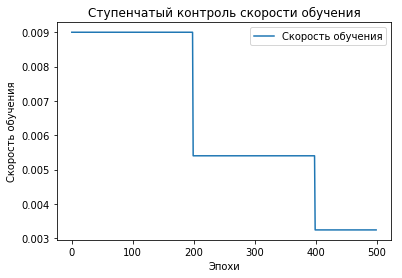

In [53]:
import matplotlib.pyplot as plt



plt.plot( lrate_drop, '-', label='Скорость обучения')
plt.title('Ступенчатый контроль скорости обучения')
plt.xlabel('Эпохи')
plt.ylabel('Скорость обучения')
plt.legend()
plt.show()



In [54]:
# learning rate schedule
def step_decayExp(epoch):
    initial_lrate = 0.001
    de = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate *math.exp(-de*epoch)
    return lrate
# Это нужно только для графика
lrate_exp=[]
for i in np.arange(0,50,1):
    lr=step_decayExp(i)
    #print(i,lr)
    lrate_exp.append(lr)

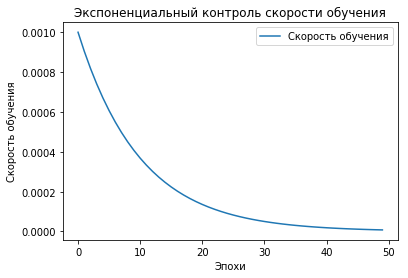

In [55]:
import matplotlib.pyplot as plt



plt.plot( lrate_exp, '-', label='Скорость обучения')
plt.title('Экспоненциальный контроль скорости обучения')
plt.xlabel('Эпохи')
plt.ylabel('Скорость обучения')
plt.legend()
plt.show()




In [56]:
# learning rate schedule
def step_decayConst(epoch):
    lrate = 0.009
    return lrate
# Это нужно только для графика
lrate_const=[]
for i in np.arange(0,50,1):
    lr=step_decayConst(i)
    #print(i,lr)
    lrate_const.append(lr)

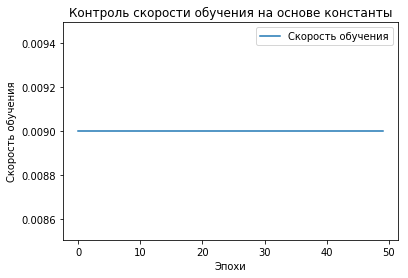

In [57]:
import matplotlib.pyplot as plt



plt.plot( lrate_const, '-', label='Скорость обучения')
plt.title('Контроль скорости обучения на основе константы')
plt.xlabel('Эпохи')
plt.ylabel('Скорость обучения')
plt.legend()
plt.show()





In [61]:
import keras

class Histories(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0],verbose=0)

        self.aucs.append(mean_squared_error(label_log[test_index], y_pred)) 
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [59]:
epochs = 1000
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
rmsprop = keras.optimizers.RMSprop(lr=0.9, rho=0.9, epsilon=None, decay=0.5)
adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.1, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adamax = keras.optimizers.Adamax(lr=0.009, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
nadam = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.00)





In [62]:
# Обучаем модель

from keras.models import model_from_json
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
json_string = model.to_json()
nb_epoch=500
val_loss= np.zeros((nb_epoch,))
val_acc=np.zeros((nb_epoch,))
loss= np.zeros((nb_epoch,))
acc=np.zeros((nb_epoch,))
pred_train = np.zeros((ntrain,1) )
#pred_test=np.zeros((ntest,nb_classes))
i=0
val_loss_ar = []
loss_ar = []
for train_index, test_index in  kf.split(xall):
    model = model_from_json(json_string)
    model.compile(loss='mean_squared_error', optimizer=adamax)
    histories = Histories()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=200, min_lr=0.0002)
#saves the model weights after each epoch if the validation loss decreased
    eStop=EarlyStopping(monitor='val_loss', patience=1000, verbose=2)
    lrate = LearningRateScheduler(step_decay)
    s=str(i)+"weights.hdf5"
    print(s)
    checkpointer = ModelCheckpoint(filepath=s,  monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
#model.compile(loss='categorical_crossentropy',  optimizer=sgd,  metrics=['accuracy'])

    callbacks_list = [histories, lrate, checkpointer, eStop, reduce_lr ]
    hist=model.fit(xall[train_index], label_log[train_index], batch_size=200, epochs=nb_epoch, validation_data=(xall[test_index], label_log[test_index]), callbacks=callbacks_list, shuffle=True, verbose=1)
    val_loss_ar.append(val_loss+hist.history['val_loss'])
    val_loss = val_loss+hist.history['val_loss']
    print(val_loss)
    loss_ar.append(loss+hist.history['loss'])
    loss = loss+hist.history['loss']
    
    model.load_weights(s)
    # Оцениваем качество обучения модели на тестовых данных
    scores = model.evaluate(xall[test_index], label_log[test_index], verbose=1)
    pr=model.predict(xall[test_index])
    pred_train[test_index]=pr
    err=mean_squared_error(label_log[test_index], pr)
    print("Fold", i, "Точность работы на тестовых данных:",  err, scores)
    #pred_test=pred_test+model.predict(x_test)
    i+=1

0weights.hdf5
Train on 24170 samples, validate on 6043 samples
Epoch 1/500
24170/24170 [==============================] - 1s 42us/step - loss: 1.3503 - val_loss: 0.6119

Epoch 00001: val_loss improved from inf to 0.61194, saving model to 0weights.hdf5
Epoch 2/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.6627 - val_loss: 0.5288

Epoch 00002: val_loss improved from 0.61194 to 0.52877, saving model to 0weights.hdf5
Epoch 3/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.5405 - val_loss: 0.4231

Epoch 00003: val_loss improved from 0.52877 to 0.42313, saving model to 0weights.hdf5
Epoch 4/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.4607 - val_loss: 0.3618

Epoch 00004: val_loss improved from 0.42313 to 0.36182, saving model to 0weights.hdf5
Epoch 5/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.4144 - val_loss: 0.3209

Epoch 00005: val_loss improved from 0.36182 to 0.32088, saving

24170/24170 [==============================] - 0s 17us/step - loss: 0.1808 - val_loss: 0.1505

Epoch 00097: val_loss did not improve from 0.14693
Epoch 98/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1764 - val_loss: 0.1569

Epoch 00098: val_loss did not improve from 0.14693
Epoch 99/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1751 - val_loss: 0.1546

Epoch 00099: val_loss did not improve from 0.14693
Epoch 100/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1802 - val_loss: 0.1496

Epoch 00100: val_loss did not improve from 0.14693
Epoch 101/500
24170/24170 [==============================] - 0s 16us/step - loss: 0.1696 - val_loss: 0.1460

Epoch 00101: val_loss improved from 0.14693 to 0.14602, saving model to 0weights.hdf5
Epoch 102/500
24170/24170 [==============================] - 0s 16us/step - loss: 0.1710 - val_loss: 0.1566

Epoch 00102: val_loss did not improve from 0.14602
Epoch 103/500
24170/2

24170/24170 [==============================] - 1s 38us/step - loss: 0.1647 - val_loss: 0.1549

Epoch 00147: val_loss did not improve from 0.13980
Epoch 148/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1677 - val_loss: 0.1382

Epoch 00148: val_loss improved from 0.13980 to 0.13820, saving model to 0weights.hdf5
Epoch 149/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1681 - val_loss: 0.1544

Epoch 00149: val_loss did not improve from 0.13820
Epoch 150/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1659 - val_loss: 0.1412

Epoch 00150: val_loss did not improve from 0.13820
Epoch 151/500
24170/24170 [==============================] - 1s 33us/step - loss: 0.1614 - val_loss: 0.1441

Epoch 00151: val_loss did not improve from 0.13820
Epoch 152/500
24170/24170 [==============================] - 1s 31us/step - loss: 0.1632 - val_loss: 0.1455

Epoch 00152: val_loss did not improve from 0.13820
Epoch 153/500
24170

24170/24170 [==============================] - 0s 17us/step - loss: 0.1543 - val_loss: 0.1337

Epoch 00197: val_loss did not improve from 0.12872
Epoch 198/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1544 - val_loss: 0.1316

Epoch 00198: val_loss did not improve from 0.12872
Epoch 199/500
24170/24170 [==============================] - 0s 16us/step - loss: 0.1565 - val_loss: 0.1392

Epoch 00199: val_loss did not improve from 0.12872
Epoch 200/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1435 - val_loss: 0.1314

Epoch 00200: val_loss did not improve from 0.12872
Epoch 201/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1405 - val_loss: 0.1328

Epoch 00201: val_loss did not improve from 0.12872
Epoch 202/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1467 - val_loss: 0.1264

Epoch 00202: val_loss improved from 0.12872 to 0.12637, saving model to 0weights.hdf5
Epoch 203/500
24170

24170/24170 [==============================] - 1s 21us/step - loss: 0.1299 - val_loss: 0.1309

Epoch 00298: val_loss did not improve from 0.12081
Epoch 299/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1350 - val_loss: 0.1218

Epoch 00299: val_loss did not improve from 0.12081
Epoch 300/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1362 - val_loss: 0.1200

Epoch 00300: val_loss improved from 0.12081 to 0.11996, saving model to 0weights.hdf5
Epoch 301/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1294 - val_loss: 0.1254

Epoch 00301: val_loss did not improve from 0.11996
Epoch 302/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1338 - val_loss: 0.1376

Epoch 00302: val_loss did not improve from 0.11996
Epoch 303/500
24170/24170 [==============================] - 1s 22us/step - loss: 0.1313 - val_loss: 0.1264

Epoch 00303: val_loss did not improve from 0.11996
Epoch 304/500
24170

24170/24170 [==============================] - 0s 17us/step - loss: 0.1309 - val_loss: 0.1298

Epoch 00349: val_loss did not improve from 0.11910
Epoch 350/500
24170/24170 [==============================] - 1s 22us/step - loss: 0.1262 - val_loss: 0.1490

Epoch 00350: val_loss did not improve from 0.11910
Epoch 351/500
24170/24170 [==============================] - 1s 25us/step - loss: 0.1292 - val_loss: 0.1249

Epoch 00351: val_loss did not improve from 0.11910
Epoch 352/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1277 - val_loss: 0.1479

Epoch 00352: val_loss did not improve from 0.11910
Epoch 353/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1313 - val_loss: 0.1351

Epoch 00353: val_loss did not improve from 0.11910
Epoch 354/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1321 - val_loss: 0.1298

Epoch 00354: val_loss did not improve from 0.11910
Epoch 355/500
24170/24170 [===========================

24170/24170 [==============================] - 0s 20us/step - loss: 0.1161 - val_loss: 0.1237

Epoch 00451: val_loss did not improve from 0.11710
Epoch 452/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1180 - val_loss: 0.1210

Epoch 00452: val_loss did not improve from 0.11710
Epoch 453/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1159 - val_loss: 0.1318

Epoch 00453: val_loss did not improve from 0.11710
Epoch 454/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1173 - val_loss: 0.1256

Epoch 00454: val_loss did not improve from 0.11710
Epoch 455/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1158 - val_loss: 0.1224

Epoch 00455: val_loss did not improve from 0.11710
Epoch 456/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1175 - val_loss: 0.1234

Epoch 00456: val_loss did not improve from 0.11710
Epoch 457/500
24170/24170 [===========================

6043/6043 [==============================] - 0s 15us/step
Fold 0 Точность работы на тестовых данных: 0.11710390540507555 0.11710390453317022
1weights.hdf5
Train on 24170 samples, validate on 6043 samples
Epoch 1/500
24170/24170 [==============================] - 1s 39us/step - loss: 1.3587 - val_loss: 0.5192

Epoch 00001: val_loss improved from inf to 0.51917, saving model to 1weights.hdf5
Epoch 2/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.6989 - val_loss: 0.4869

Epoch 00002: val_loss improved from 0.51917 to 0.48692, saving model to 1weights.hdf5
Epoch 3/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.6211 - val_loss: 0.3923

Epoch 00003: val_loss improved from 0.48692 to 0.39232, saving model to 1weights.hdf5
Epoch 4/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.4922 - val_loss: 0.3223

Epoch 00004: val_loss improved from 0.39232 to 0.32229, saving model to 1weights.hdf5
Epoch 5/500
24170/24170 [===

24170/24170 [==============================] - 0s 17us/step - loss: 0.2145 - val_loss: 0.1968

Epoch 00048: val_loss did not improve from 0.15125
Epoch 49/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.2117 - val_loss: 0.1935

Epoch 00049: val_loss did not improve from 0.15125
Epoch 50/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.2082 - val_loss: 0.1598

Epoch 00050: val_loss did not improve from 0.15125
Epoch 51/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.2204 - val_loss: 0.1533

Epoch 00051: val_loss did not improve from 0.15125
Epoch 52/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.2109 - val_loss: 0.1944

Epoch 00052: val_loss did not improve from 0.15125
Epoch 53/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.2133 - val_loss: 0.1737

Epoch 00053: val_loss did not improve from 0.15125
Epoch 54/500
24170/24170 [==============================] -


Epoch 00148: val_loss did not improve from 0.13609
Epoch 149/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1818 - val_loss: 0.1688

Epoch 00149: val_loss did not improve from 0.13609
Epoch 150/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1752 - val_loss: 0.1363

Epoch 00150: val_loss did not improve from 0.13609
Epoch 151/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1738 - val_loss: 0.1407

Epoch 00151: val_loss did not improve from 0.13609
Epoch 152/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1793 - val_loss: 0.1354

Epoch 00152: val_loss improved from 0.13609 to 0.13538, saving model to 1weights.hdf5
Epoch 153/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1732 - val_loss: 0.1366

Epoch 00153: val_loss did not improve from 0.13538
Epoch 154/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1725 - val_loss: 0.1434

Epoc

24170/24170 [==============================] - 0s 18us/step - loss: 0.1588 - val_loss: 0.1396

Epoch 00249: val_loss did not improve from 0.12642
Epoch 250/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1577 - val_loss: 0.1396

Epoch 00250: val_loss did not improve from 0.12642
Epoch 251/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1573 - val_loss: 0.1349

Epoch 00251: val_loss did not improve from 0.12642
Epoch 252/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1584 - val_loss: 0.1378

Epoch 00252: val_loss did not improve from 0.12642
Epoch 253/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1584 - val_loss: 0.1312

Epoch 00253: val_loss did not improve from 0.12642
Epoch 254/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1571 - val_loss: 0.1345

Epoch 00254: val_loss did not improve from 0.12642
Epoch 255/500
24170/24170 [===========================

24170/24170 [==============================] - 0s 17us/step - loss: 0.1524 - val_loss: 0.1304

Epoch 00351: val_loss did not improve from 0.12349
Epoch 352/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1497 - val_loss: 0.1317

Epoch 00352: val_loss did not improve from 0.12349
Epoch 353/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1477 - val_loss: 0.1265

Epoch 00353: val_loss did not improve from 0.12349
Epoch 354/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1487 - val_loss: 0.1350

Epoch 00354: val_loss did not improve from 0.12349
Epoch 355/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1496 - val_loss: 0.1358

Epoch 00355: val_loss did not improve from 0.12349
Epoch 356/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1453 - val_loss: 0.1341

Epoch 00356: val_loss did not improve from 0.12349
Epoch 357/500
24170/24170 [===========================

24170/24170 [==============================] - 0s 17us/step - loss: 0.1372 - val_loss: 0.1266

Epoch 00402: val_loss did not improve from 0.12317
Epoch 403/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1359 - val_loss: 0.1249

Epoch 00403: val_loss did not improve from 0.12317
Epoch 404/500
24170/24170 [==============================] - 0s 21us/step - loss: 0.1396 - val_loss: 0.1276

Epoch 00404: val_loss did not improve from 0.12317
Epoch 405/500
24170/24170 [==============================] - 1s 21us/step - loss: 0.1355 - val_loss: 0.1222

Epoch 00405: val_loss improved from 0.12317 to 0.12222, saving model to 1weights.hdf5
Epoch 406/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1338 - val_loss: 0.1260

Epoch 00406: val_loss did not improve from 0.12222
Epoch 407/500
24170/24170 [==============================] - 1s 27us/step - loss: 0.1329 - val_loss: 0.1252

Epoch 00407: val_loss did not improve from 0.12222
Epoch 408/500
24170

6043/6043 [==============================] - 0s 14us/step
Fold 1 Точность работы на тестовых данных: 0.11650085973832602 0.11650085987144998
2weights.hdf5
Train on 24170 samples, validate on 6043 samples
Epoch 1/500
24170/24170 [==============================] - 1s 41us/step - loss: 1.3174 - val_loss: 0.5863

Epoch 00001: val_loss improved from inf to 0.58630, saving model to 2weights.hdf5
Epoch 2/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.6679 - val_loss: 0.4968

Epoch 00002: val_loss improved from 0.58630 to 0.49682, saving model to 2weights.hdf5
Epoch 3/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.5265 - val_loss: 0.4429

Epoch 00003: val_loss improved from 0.49682 to 0.44291, saving model to 2weights.hdf5
Epoch 4/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.4417 - val_loss: 0.3227

Epoch 00004: val_loss improved from 0.44291 to 0.32265, saving model to 2weights.hdf5
Epoch 5/500
24170/24170 [===

24170/24170 [==============================] - 1s 23us/step - loss: 0.1774 - val_loss: 0.1753

Epoch 00097: val_loss did not improve from 0.15480
Epoch 98/500
24170/24170 [==============================] - 1s 31us/step - loss: 0.1716 - val_loss: 0.2241

Epoch 00098: val_loss did not improve from 0.15480
Epoch 99/500
24170/24170 [==============================] - 1s 24us/step - loss: 0.1779 - val_loss: 0.1732

Epoch 00099: val_loss did not improve from 0.15480
Epoch 100/500
24170/24170 [==============================] - 1s 22us/step - loss: 0.1792 - val_loss: 0.1599

Epoch 00100: val_loss did not improve from 0.15480
Epoch 101/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1709 - val_loss: 0.1656

Epoch 00101: val_loss did not improve from 0.15480
Epoch 102/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1723 - val_loss: 0.1754

Epoch 00102: val_loss did not improve from 0.15480
Epoch 103/500
24170/24170 [=============================

24170/24170 [==============================] - 0s 18us/step - loss: 0.1612 - val_loss: 0.1648

Epoch 00148: val_loss did not improve from 0.15143
Epoch 149/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1610 - val_loss: 0.1668

Epoch 00149: val_loss did not improve from 0.15143
Epoch 150/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1613 - val_loss: 0.1586

Epoch 00150: val_loss did not improve from 0.15143
Epoch 151/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1591 - val_loss: 0.1738

Epoch 00151: val_loss did not improve from 0.15143
Epoch 152/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1644 - val_loss: 0.1629

Epoch 00152: val_loss did not improve from 0.15143
Epoch 153/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1636 - val_loss: 0.1555

Epoch 00153: val_loss did not improve from 0.15143
Epoch 154/500
24170/24170 [===========================

24170/24170 [==============================] - 0s 19us/step - loss: 0.1583 - val_loss: 0.1837

Epoch 00199: val_loss did not improve from 0.14979
Epoch 200/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1494 - val_loss: 0.1578

Epoch 00200: val_loss did not improve from 0.14979
Epoch 201/500
24170/24170 [==============================] - 1s 28us/step - loss: 0.1456 - val_loss: 0.1760

Epoch 00201: val_loss did not improve from 0.14979
Epoch 202/500
24170/24170 [==============================] - 1s 27us/step - loss: 0.1488 - val_loss: 0.1614

Epoch 00202: val_loss did not improve from 0.14979
Epoch 203/500
24170/24170 [==============================] - 0s 21us/step - loss: 0.1491 - val_loss: 0.1605

Epoch 00203: val_loss did not improve from 0.14979
Epoch 204/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1496 - val_loss: 0.1653

Epoch 00204: val_loss did not improve from 0.14979
Epoch 205/500
24170/24170 [===========================

24170/24170 [==============================] - 1s 31us/step - loss: 0.1347 - val_loss: 0.1475

Epoch 00301: val_loss did not improve from 0.14610
Epoch 302/500
24170/24170 [==============================] - 1s 25us/step - loss: 0.1407 - val_loss: 0.1540

Epoch 00302: val_loss did not improve from 0.14610
Epoch 303/500
24170/24170 [==============================] - 1s 28us/step - loss: 0.1337 - val_loss: 0.1536

Epoch 00303: val_loss did not improve from 0.14610
Epoch 304/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1368 - val_loss: 0.1580

Epoch 00304: val_loss did not improve from 0.14610
Epoch 305/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1331 - val_loss: 0.1451

Epoch 00305: val_loss improved from 0.14610 to 0.14511, saving model to 2weights.hdf5
Epoch 306/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1353 - val_loss: 0.1525

Epoch 00306: val_loss did not improve from 0.14511
Epoch 307/500
24170

24170/24170 [==============================] - 0s 17us/step - loss: 0.1336 - val_loss: 0.1531

Epoch 00352: val_loss did not improve from 0.14334
Epoch 353/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1298 - val_loss: 0.1539

Epoch 00353: val_loss did not improve from 0.14334
Epoch 354/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1344 - val_loss: 0.1440

Epoch 00354: val_loss did not improve from 0.14334
Epoch 355/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1304 - val_loss: 0.1438

Epoch 00355: val_loss did not improve from 0.14334
Epoch 356/500
24170/24170 [==============================] - 0s 18us/step - loss: 0.1331 - val_loss: 0.1446

Epoch 00356: val_loss did not improve from 0.14334
Epoch 357/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1303 - val_loss: 0.1663

Epoch 00357: val_loss did not improve from 0.14334
Epoch 358/500
24170/24170 [===========================

24170/24170 [==============================] - 0s 17us/step - loss: 0.1193 - val_loss: 0.1463

Epoch 00403: val_loss did not improve from 0.14060
Epoch 404/500
24170/24170 [==============================] - 0s 19us/step - loss: 0.1202 - val_loss: 0.1388

Epoch 00404: val_loss improved from 0.14060 to 0.13880, saving model to 2weights.hdf5
Epoch 405/500
24170/24170 [==============================] - 0s 20us/step - loss: 0.1204 - val_loss: 0.1541

Epoch 00405: val_loss did not improve from 0.13880
Epoch 406/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1211 - val_loss: 0.1441

Epoch 00406: val_loss did not improve from 0.13880
Epoch 407/500
24170/24170 [==============================] - 1s 22us/step - loss: 0.1182 - val_loss: 0.1384

Epoch 00407: val_loss improved from 0.13880 to 0.13835, saving model to 2weights.hdf5
Epoch 408/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1192 - val_loss: 0.1479

Epoch 00408: val_loss did not impro


Epoch 00453: val_loss did not improve from 0.13521
Epoch 454/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1160 - val_loss: 0.1393

Epoch 00454: val_loss did not improve from 0.13521
Epoch 455/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1165 - val_loss: 0.1344

Epoch 00455: val_loss improved from 0.13521 to 0.13444, saving model to 2weights.hdf5
Epoch 456/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1171 - val_loss: 0.1313

Epoch 00456: val_loss improved from 0.13444 to 0.13135, saving model to 2weights.hdf5
Epoch 457/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1171 - val_loss: 0.1357

Epoch 00457: val_loss did not improve from 0.13135
Epoch 458/500
24170/24170 [==============================] - 0s 17us/step - loss: 0.1163 - val_loss: 0.1382

Epoch 00458: val_loss did not improve from 0.13135
Epoch 459/500
24170/24170 [==============================] - 0s 17us/step - lo

6043/6043 [==============================] - 0s 19us/step
Fold 2 Точность работы на тестовых данных: 0.13134986611821933 0.13134986550064645
3weights.hdf5
Train on 24171 samples, validate on 6042 samples
Epoch 1/500
24171/24171 [==============================] - 1s 53us/step - loss: 1.2586 - val_loss: 0.8763

Epoch 00001: val_loss improved from inf to 0.87626, saving model to 3weights.hdf5
Epoch 2/500
24171/24171 [==============================] - 1s 21us/step - loss: 0.6144 - val_loss: 0.8155

Epoch 00002: val_loss improved from 0.87626 to 0.81546, saving model to 3weights.hdf5
Epoch 3/500
24171/24171 [==============================] - 1s 21us/step - loss: 0.5251 - val_loss: 0.6545

Epoch 00003: val_loss improved from 0.81546 to 0.65447, saving model to 3weights.hdf5
Epoch 4/500
24171/24171 [==============================] - 1s 22us/step - loss: 0.4290 - val_loss: 0.5401

Epoch 00004: val_loss improved from 0.65447 to 0.54010, saving model to 3weights.hdf5
Epoch 5/500
24171/24171 [===


Epoch 00046: val_loss did not improve from 0.27760
Epoch 47/500
24171/24171 [==============================] - 1s 23us/step - loss: 0.1804 - val_loss: 0.3104

Epoch 00047: val_loss did not improve from 0.27760
Epoch 48/500
24171/24171 [==============================] - 0s 18us/step - loss: 0.1734 - val_loss: 0.3013

Epoch 00048: val_loss did not improve from 0.27760
Epoch 49/500
24171/24171 [==============================] - 1s 24us/step - loss: 0.1828 - val_loss: 0.3632

Epoch 00049: val_loss did not improve from 0.27760
Epoch 50/500
24171/24171 [==============================] - 1s 22us/step - loss: 0.1824 - val_loss: 0.3231

Epoch 00050: val_loss did not improve from 0.27760
Epoch 51/500
24171/24171 [==============================] - 1s 35us/step - loss: 0.1807 - val_loss: 0.2978

Epoch 00051: val_loss did not improve from 0.27760
Epoch 52/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1759 - val_loss: 0.2740

Epoch 00052: val_loss improved from 0.27760 t

24171/24171 [==============================] - 0s 20us/step - loss: 0.1401 - val_loss: 0.2707

Epoch 00148: val_loss did not improve from 0.26095
Epoch 149/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1452 - val_loss: 0.2777

Epoch 00149: val_loss did not improve from 0.26095
Epoch 150/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1413 - val_loss: 0.2724

Epoch 00150: val_loss did not improve from 0.26095
Epoch 151/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1387 - val_loss: 0.2795

Epoch 00151: val_loss did not improve from 0.26095
Epoch 152/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1377 - val_loss: 0.2865

Epoch 00152: val_loss did not improve from 0.26095
Epoch 153/500
24171/24171 [==============================] - 0s 18us/step - loss: 0.1381 - val_loss: 0.2970

Epoch 00153: val_loss did not improve from 0.26095
Epoch 154/500
24171/24171 [===========================


Epoch 00198: val_loss did not improve from 0.25376
Epoch 199/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1345 - val_loss: 0.2889

Epoch 00199: val_loss did not improve from 0.25376
Epoch 200/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1285 - val_loss: 0.2589

Epoch 00200: val_loss did not improve from 0.25376
Epoch 201/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1281 - val_loss: 0.2736

Epoch 00201: val_loss did not improve from 0.25376
Epoch 202/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1250 - val_loss: 0.2836

Epoch 00202: val_loss did not improve from 0.25376
Epoch 203/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1271 - val_loss: 0.2827

Epoch 00203: val_loss did not improve from 0.25376
Epoch 204/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1259 - val_loss: 0.2651

Epoch 00204: val_loss did not improve f


Epoch 00249: val_loss did not improve from 0.25264
Epoch 250/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1190 - val_loss: 0.2794

Epoch 00250: val_loss did not improve from 0.25264
Epoch 251/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1208 - val_loss: 0.2892

Epoch 00251: val_loss did not improve from 0.25264
Epoch 252/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1183 - val_loss: 0.2766

Epoch 00252: val_loss did not improve from 0.25264
Epoch 253/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1229 - val_loss: 0.2942

Epoch 00253: val_loss did not improve from 0.25264
Epoch 254/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1200 - val_loss: 0.2853

Epoch 00254: val_loss did not improve from 0.25264
Epoch 255/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1194 - val_loss: 0.2797

Epoch 00255: val_loss did not improve f

24171/24171 [==============================] - 0s 17us/step - loss: 0.1157 - val_loss: 0.3009

Epoch 00301: val_loss did not improve from 0.25264
Epoch 302/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1167 - val_loss: 0.2885

Epoch 00302: val_loss did not improve from 0.25264
Epoch 303/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1140 - val_loss: 0.2812

Epoch 00303: val_loss did not improve from 0.25264
Epoch 304/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1115 - val_loss: 0.3049

Epoch 00304: val_loss did not improve from 0.25264
Epoch 305/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1118 - val_loss: 0.3110

Epoch 00305: val_loss did not improve from 0.25264
Epoch 306/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1117 - val_loss: 0.3046

Epoch 00306: val_loss did not improve from 0.25264
Epoch 307/500
24171/24171 [===========================

24171/24171 [==============================] - 0s 17us/step - loss: 0.1088 - val_loss: 0.3317

Epoch 00403: val_loss did not improve from 0.25264
Epoch 404/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1087 - val_loss: 0.3297

Epoch 00404: val_loss did not improve from 0.25264
Epoch 405/500
24171/24171 [==============================] - 0s 16us/step - loss: 0.1081 - val_loss: 0.3318

Epoch 00405: val_loss did not improve from 0.25264
Epoch 406/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1100 - val_loss: 0.3371

Epoch 00406: val_loss did not improve from 0.25264
Epoch 407/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1094 - val_loss: 0.3450

Epoch 00407: val_loss did not improve from 0.25264
Epoch 408/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1119 - val_loss: 0.3267

Epoch 00408: val_loss did not improve from 0.25264
Epoch 409/500
24171/24171 [===========================

6042/6042 [==============================] - 0s 15us/step
Fold 3 Точность работы на тестовых данных: 0.25263604095808884 0.25263604126162814
4weights.hdf5
Train on 24171 samples, validate on 6042 samples
Epoch 1/500
24171/24171 [==============================] - 1s 46us/step - loss: 1.3188 - val_loss: 0.6638

Epoch 00001: val_loss improved from inf to 0.66379, saving model to 4weights.hdf5
Epoch 2/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.6601 - val_loss: 0.6772

Epoch 00002: val_loss did not improve from 0.66379
Epoch 3/500
24171/24171 [==============================] - 0s 18us/step - loss: 0.5613 - val_loss: 0.5185

Epoch 00003: val_loss improved from 0.66379 to 0.51852, saving model to 4weights.hdf5
Epoch 4/500
24171/24171 [==============================] - 0s 18us/step - loss: 0.4585 - val_loss: 0.5168

Epoch 00004: val_loss improved from 0.51852 to 0.51683, saving model to 4weights.hdf5
Epoch 5/500
24171/24171 [==============================] - 0s 1

24171/24171 [==============================] - 0s 17us/step - loss: 0.2027 - val_loss: 0.2739

Epoch 00049: val_loss did not improve from 0.25994
Epoch 50/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1935 - val_loss: 0.2472

Epoch 00050: val_loss improved from 0.25994 to 0.24724, saving model to 4weights.hdf5
Epoch 51/500
24171/24171 [==============================] - 0s 18us/step - loss: 0.1986 - val_loss: 0.2716

Epoch 00051: val_loss did not improve from 0.24724
Epoch 52/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1970 - val_loss: 0.2705

Epoch 00052: val_loss did not improve from 0.24724
Epoch 53/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.2124 - val_loss: 0.2781

Epoch 00053: val_loss did not improve from 0.24724
Epoch 54/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1935 - val_loss: 0.2632

Epoch 00054: val_loss did not improve from 0.24724
Epoch 55/500
24171/24171

24171/24171 [==============================] - 0s 17us/step - loss: 0.1801 - val_loss: 0.2231

Epoch 00099: val_loss did not improve from 0.21824
Epoch 100/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1771 - val_loss: 0.2266

Epoch 00100: val_loss did not improve from 0.21824
Epoch 101/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1914 - val_loss: 0.2130

Epoch 00101: val_loss improved from 0.21824 to 0.21301, saving model to 4weights.hdf5
Epoch 102/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1730 - val_loss: 0.2239

Epoch 00102: val_loss did not improve from 0.21301
Epoch 103/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1754 - val_loss: 0.2277

Epoch 00103: val_loss did not improve from 0.21301
Epoch 104/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1809 - val_loss: 0.2313

Epoch 00104: val_loss did not improve from 0.21301
Epoch 105/500
24171

24171/24171 [==============================] - 0s 17us/step - loss: 0.1507 - val_loss: 0.2091

Epoch 00200: val_loss did not improve from 0.19349
Epoch 201/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1537 - val_loss: 0.2023

Epoch 00201: val_loss did not improve from 0.19349
Epoch 202/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1525 - val_loss: 0.2025

Epoch 00202: val_loss did not improve from 0.19349
Epoch 203/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1533 - val_loss: 0.1969

Epoch 00203: val_loss did not improve from 0.19349
Epoch 204/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1529 - val_loss: 0.2180

Epoch 00204: val_loss did not improve from 0.19349
Epoch 205/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1477 - val_loss: 0.2013

Epoch 00205: val_loss did not improve from 0.19349
Epoch 206/500
24171/24171 [===========================

24171/24171 [==============================] - 0s 17us/step - loss: 0.1329 - val_loss: 0.2049

Epoch 00300: val_loss did not improve from 0.17135
Epoch 301/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1350 - val_loss: 0.1779

Epoch 00301: val_loss did not improve from 0.17135
Epoch 302/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1366 - val_loss: 0.1857

Epoch 00302: val_loss did not improve from 0.17135
Epoch 303/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1345 - val_loss: 0.1712

Epoch 00303: val_loss improved from 0.17135 to 0.17123, saving model to 4weights.hdf5
Epoch 304/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1376 - val_loss: 0.1909

Epoch 00304: val_loss did not improve from 0.17123
Epoch 305/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1369 - val_loss: 0.1789

Epoch 00305: val_loss did not improve from 0.17123
Epoch 306/500
24171

24171/24171 [==============================] - 0s 17us/step - loss: 0.1324 - val_loss: 0.1821

Epoch 00351: val_loss did not improve from 0.17123
Epoch 352/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1344 - val_loss: 0.1928

Epoch 00352: val_loss did not improve from 0.17123
Epoch 353/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1317 - val_loss: 0.1762

Epoch 00353: val_loss did not improve from 0.17123
Epoch 354/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1309 - val_loss: 0.1923

Epoch 00354: val_loss did not improve from 0.17123
Epoch 355/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1307 - val_loss: 0.1905

Epoch 00355: val_loss did not improve from 0.17123
Epoch 356/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1313 - val_loss: 0.1876

Epoch 00356: val_loss did not improve from 0.17123
Epoch 357/500
24171/24171 [===========================

24171/24171 [==============================] - 0s 17us/step - loss: 0.1216 - val_loss: 0.1792

Epoch 00453: val_loss did not improve from 0.16864
Epoch 454/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1221 - val_loss: 0.1730

Epoch 00454: val_loss did not improve from 0.16864
Epoch 455/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1249 - val_loss: 0.1731

Epoch 00455: val_loss did not improve from 0.16864
Epoch 456/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1223 - val_loss: 0.1823

Epoch 00456: val_loss did not improve from 0.16864
Epoch 457/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1211 - val_loss: 0.1752

Epoch 00457: val_loss did not improve from 0.16864
Epoch 458/500
24171/24171 [==============================] - 0s 17us/step - loss: 0.1211 - val_loss: 0.1856

Epoch 00458: val_loss did not improve from 0.16864
Epoch 459/500
24171/24171 [===========================

6042/6042 [==============================] - 0s 16us/step
Fold 4 Точность работы на тестовых данных: 0.16534561321902158 0.16534561376053147


In [64]:
err=mean_squared_error(label_log, pred_train)
print("error", err)

error 0.1565837881459


500


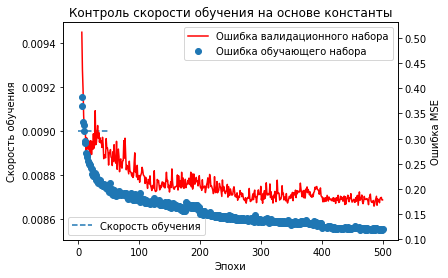

In [65]:
import matplotlib.pyplot as plt
print(len(loss))
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = np.arange(1, len(loss) + 1)
fig, ax  = plt.subplots()

ax1 = ax
ax2 = ax.twinx()


ax2.plot(epochs[5:], val_loss[5:], 'r', label='Ошибка валидационного набора')
ax2.plot(epochs[5:], loss[5:], 'o', label='Ошибка обучающего набора')
ax1.plot(lrate_const, '--', label='Скорость обучения') 
ax1.label_outer()
plt.title('Контроль скорости обучения на основе константы')
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Скорость обучения')
ax2.set_ylabel('Ошибка MSE')
ax1.legend(loc = 3)
ax2.legend()
plt.show()
#Контроль скорости обучения на основе константы




In [67]:
wr=1./NFOLDS
predTest = np.zeros((ntest,1))
for i in np.arange(NFOLDS):    
    s=str(i)+"weights.hdf5"
    print(s)
    model = model_from_json(json_string)
    model.compile(loss='mse', optimizer=sgd)
    model.load_weights(s)
   
    predT=model.predict(ttest)
    

0weights.hdf5
1weights.hdf5
2weights.hdf5
3weights.hdf5
4weights.hdf5


In [88]:
pp = []
for s in predT:
    pp.append(s[0])

In [89]:
pp

[3.3976712,
 3.1120172,
 2.6526413,
 2.3300238,
 1.8458766,
 1.8054307,
 1.791538,
 1.7536047,
 3.242107,
 2.686996,
 2.1221418,
 1.8392344,
 1.4932618,
 1.4478649,
 1.4281924,
 1.3935814,
 3.3402958,
 3.027413,
 2.5028968,
 2.2186756,
 1.8684993,
 1.8634948,
 1.856226,
 1.8295246,
 3.4257004,
 3.1672435,
 2.7132156,
 2.3857563,
 1.8842244,
 1.8546187,
 1.8467253,
 1.8177533,
 3.3055816,
 2.8210654,
 2.227467,
 1.8950833,
 1.593689,
 1.5270424,
 1.5103195,
 1.445766,
 2.2832704,
 3.0859323,
 2.6620011,
 3.4138904,
 3.1152558,
 2.8109927,
 2.5908966,
 2.451593,
 2.431014,
 2.4210567,
 2.3862367,
 4.5500746,
 3.9923244,
 3.8074422,
 1.8924868,
 3.0067372,
 2.0258574,
 2.6287296,
 2.2126453,
 2.0125546,
 1.9313536,
 1.8895249,
 3.2212799,
 2.9611526,
 2.2820828,
 2.0514967,
 1.583096,
 1.5097982,
 1.5023525,
 1.5126781,
 2.3630872,
 2.010232,
 1.7563691,
 1.6306679,
 2.5776892,
 3.2996092,
 2.9221625,
 2.1367948,
 1.8356997,
 1.4224775,
 1.4107807,
 1.394234,
 1.3669245,
 2.7067482,
 2.62

In [90]:
preds = np.expm1(pp)
preds

array([28.894402, 21.466316, 13.191473, ...,  4.383293, 43.84926 ,
       56.824062], dtype=float32)

In [91]:
preds = pd.DataFrame({"id": idx, "cost": preds})
preds.to_csv('depplearning.csv', index=False)